#Instal lalu restart session

In [ ]:
!pip install tensorflowjs
!pip install TensorFlow==2.15.0
!pip install tensorflow-decision-forests==1.8.1

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [ ]:
import tensorflow as tf
print(tf.__version__)  # Versi TensorFlow


2.15.0


# Mulai dari sini

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path directory
base_dir = '/content/drive/MyDrive/Project_Bangkit/Uang_Baru'
train_dir = os.path.join(base_dir, 'training_set')
test_dir = os.path.join(base_dir, 'test_set')
validation_dir = os.path.join(base_dir, 'validation_set')

# money categories
categories = ['100k', '50k', '20k', '10k', '5k', '2k', '1k']

# Buat direktori jika belum ada
for folder in [train_dir, test_dir, validation_dir]:
    os.makedirs(folder, exist_ok=True)
    for category in categories:
        os.makedirs(os.path.join(folder, category), exist_ok=True)

# Pembagian data
for category in categories:
    category_path = os.path.join(base_dir, category)
    files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    # Split data training dan sisa
    train_files, temp_files = train_test_split(files, train_size=0.8, random_state=42)

    # Split sisa menjadi validasi dan testing
    val_files, test_files = train_test_split(temp_files, train_size=0.5, random_state=42)

    # Salin file ke masing-masing folder
    for file in train_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(train_dir, category, file))
    for file in val_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(validation_dir, category, file))
    for file in test_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(test_dir, category, file))
print("[INFO] Proses pembagian dataset selesai.")

[INFO] Proses pembagian dataset selesai.


In [ ]:
# Konfigurasi augmentasi dan generator
IMG_SIZE = (224, 224)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
# Generator untuk data tanpa augmentasi
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:

# Mapping category
desired_mapping = {'100k': 6, '50k': 5, '20k': 4, '10k': 3, '5k': 2, '2k': 1, '1k': 0}

# Generator untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='categorical'
)

# Generator untuk validasi
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='categorical'
)

# Generator untuk testing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='categorical'
)

# Update label generator
def update_generator_labels(generator):
    generator.classes = np.array([
        desired_mapping[os.path.split(filename)[0].split('/')[-1]]
        for filename in generator.filenames
    ])
    generator.class_indices = desired_mapping

# Update labels
update_generator_labels(train_generator)
update_generator_labels(validation_generator)
update_generator_labels(test_generator)

print("Pembagian dan generator dataset selesai.")

Found 1320 images belonging to 7 classes.
Found 328 images belonging to 7 classes.
Found 324 images belonging to 7 classes.
Pembagian dan generator dataset selesai.


In [ ]:
# Cek apakah label sudah sesuai mapping
def check_label_mapping(generator):
    mismatched = []
    for filename, label in zip(generator.filenames, generator.classes):
        category = os.path.split(filename)[0].split('/')[-1]
        if label != desired_mapping[category]:
            mismatched.append((filename, category, label, desired_mapping[category]))

    if mismatched:
        print("Terdapat ketidaksesuaian label:")
        for file, category, current_label, expected_label in mismatched:
            print(f"File: {file}")
            print(f"Kategori: {category}")
            print(f"Current Label: {current_label}")
            print(f"Expected Label: {expected_label}")
            print("---")
    else:
        print("Semua label sudah sesuai mapping!")

# Jalankan pengecekan
check_label_mapping(train_generator)
check_label_mapping(validation_generator)
check_label_mapping(test_generator)

Semua label sudah sesuai mapping!
Semua label sudah sesuai mapping!
Semua label sudah sesuai mapping!



Distribusi Kelas di Training Set:
100k: 181 gambar (13.71%)
50k: 217 gambar (16.44%)
20k: 171 gambar (12.95%)
10k: 201 gambar (15.23%)
5k: 181 gambar (13.71%)
2k: 222 gambar (16.82%)
1k: 147 gambar (11.14%)
Total sampel di Training Set: 1320

Distribusi Kelas di Validation Set:
100k: 48 gambar (14.63%)
50k: 54 gambar (16.46%)
20k: 36 gambar (10.98%)
10k: 51 gambar (15.55%)
5k: 48 gambar (14.63%)
2k: 57 gambar (17.38%)
1k: 34 gambar (10.37%)
Total sampel di Validation Set: 328

Distribusi Kelas di Test Set:
100k: 47 gambar (14.51%)
50k: 54 gambar (16.67%)
20k: 39 gambar (12.04%)
10k: 50 gambar (15.43%)
5k: 47 gambar (14.51%)
2k: 55 gambar (16.98%)
1k: 32 gambar (9.88%)
Total sampel di Test Set: 324


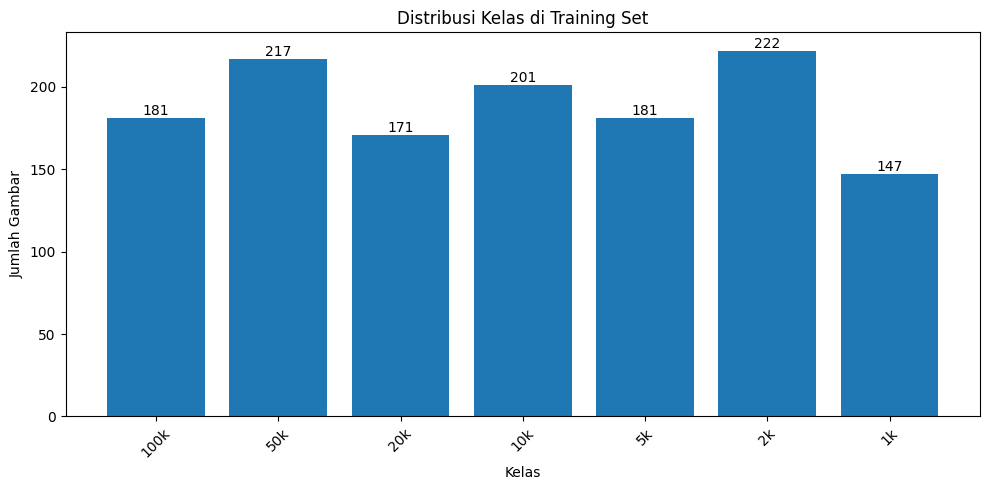

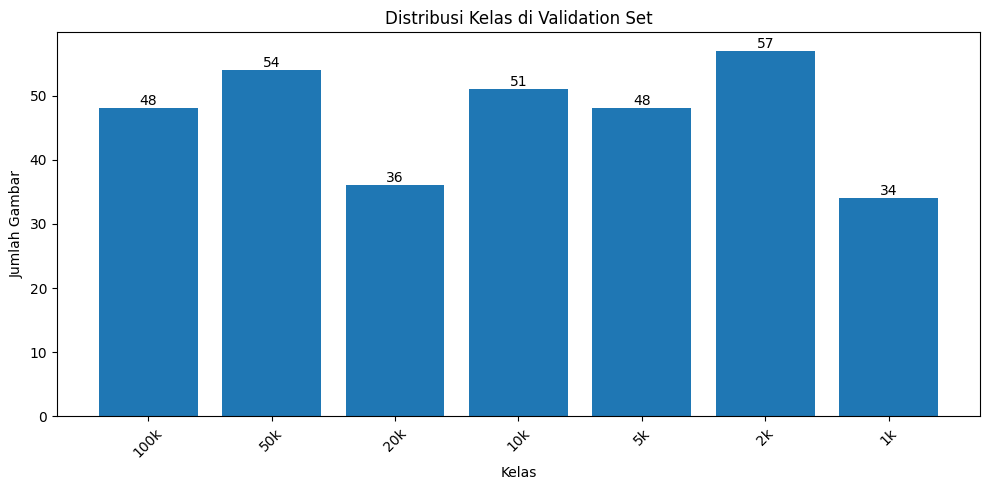

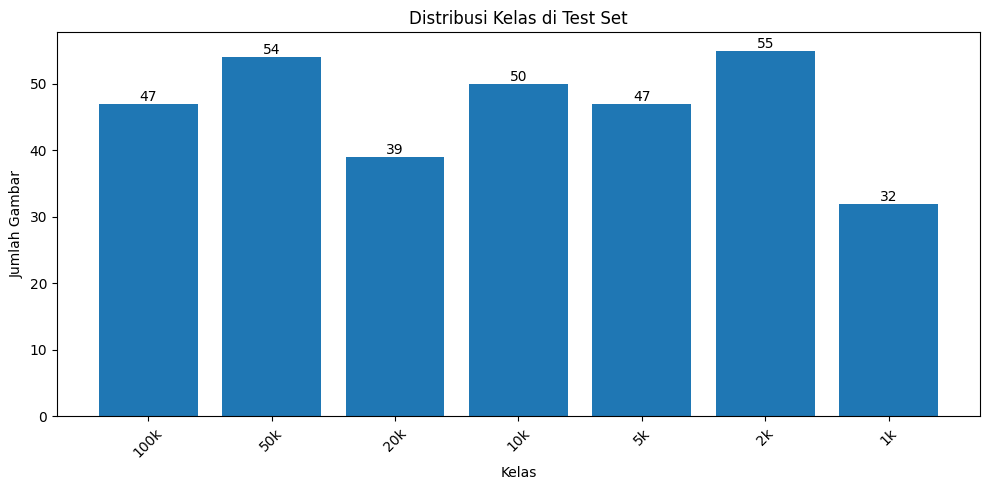


Detail Generator:
Training Generator:
Jumlah sampel: 1320
Jumlah kelas: 7
Indices kelas: {'100k': 6, '50k': 5, '20k': 4, '10k': 3, '5k': 2, '2k': 1, '1k': 0}


In [ ]:
# Cek jumlah gambar per kelas di setiap generator
def print_class_distribution(generator, set_name):
    print(f"\nDistribusi Kelas di {set_name}:")
    for class_name, class_index in generator.class_indices.items():
        class_count = list(generator.classes).count(class_index)
        total_samples = len(generator.classes)
        percentage = (class_count / total_samples) * 100
        print(f"{class_name}: {class_count} gambar ({percentage:.2f}%)")
    print(f"Total sampel di {set_name}: {len(generator.classes)}")

# Panggil fungsi untuk setiap generator
print_class_distribution(train_generator, "Training Set")
print_class_distribution(validation_generator, "Validation Set")
print_class_distribution(test_generator, "Test Set")

# Visualisasi distribusi kelas
import matplotlib.pyplot as plt

def plot_class_distribution(generator, set_name):
    # Hitung jumlah gambar per kelas
    class_counts = {}
    for class_name, class_index in generator.class_indices.items():
        class_counts[class_name] = list(generator.classes).count(class_index)

    # Buat bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(f'Distribusi Kelas di {set_name}')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.xticks(rotation=45)

    # Tambahkan label jumlah di atas setiap bar
    for i, (kelas, jumlah) in enumerate(class_counts.items()):
        plt.text(i, jumlah, str(jumlah), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Visualisasi distribusi kelas
plot_class_distribution(train_generator, "Training Set")
plot_class_distribution(validation_generator, "Validation Set")
plot_class_distribution(test_generator, "Test Set")

# Cek detail generator
print("\nDetail Generator:")
print("Training Generator:")
print("Jumlah sampel:", train_generator.samples)
print("Jumlah kelas:", train_generator.num_classes)
print("Indices kelas:", train_generator.class_indices)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import matplotlib.pyplot as plt

# Ukuran input gambar
IMG_SIZE = (224, 224)

# Membuat model menggunakan MobileNetV2
def create_mobilenetv2_model(num_classes):
    # Base model
    base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),include_top=False,weights='imagenet')
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Kompilasi model awal
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

# Buat model
model, base_model = create_mobilenetv2_model(len(categories))

# Tampilkan summary model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
83/83 [==============================] - 76s 872ms/step - loss: 1.2577 - accuracy: 0.6000 - val_loss: 0.8992 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 2/50
83/83 [==============================] - 71s 859ms/step - loss: 0.5586 - accuracy: 0.8068 - val_loss: 0.5480 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 3/50
83/83 [==============================] - 73s 881ms/step - loss: 0.3772 - accuracy: 0.8727 - val_loss: 0.3814 - val_accuracy: 0.8963 - lr: 0.0010
Epoch 4/50
83/83 [==============================] - 72s 864ms/step - loss: 0.3324 - accuracy: 0.8848 - val_loss: 0.3274 - val_accuracy: 0.8841 - lr: 0.0010
Epoch 5/50
83/83 [==============================] - 69s 830ms/step - loss: 0.3069 - accuracy: 0.8939 - val_loss: 0.3012 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 6/50
83/83 [==============================] - 70s 840ms/step - loss: 0.2685 - accuracy: 0.9068 - val_loss: 0.3065 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 7/50
83/83 [==============================] - 72s 866ms/st

In [ ]:
# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Kompilasi ulang dengan learning rate rendah
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:

# Training lanjutan
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
83/83 [==============================] - 74s 793ms/step - loss: 0.6174 - accuracy: 0.7879 - val_loss: 0.2455 - val_accuracy: 0.9329 - lr: 1.0000e-05
Epoch 2/30
83/83 [==============================] - 69s 828ms/step - loss: 0.4552 - accuracy: 0.8470 - val_loss: 0.2993 - val_accuracy: 0.9207 - lr: 1.0000e-05
Epoch 3/30
83/83 [==============================] - 65s 784ms/step - loss: 0.3799 - accuracy: 0.8682 - val_loss: 0.3503 - val_accuracy: 0.9024 - lr: 1.0000e-05
Epoch 4/30
83/83 [==============================] - 69s 836ms/step - loss: 0.3200 - accuracy: 0.8932 - val_loss: 0.3605 - val_accuracy: 0.9024 - lr: 1.0000e-05
Epoch 5/30
83/83 [==============================] - 69s 833ms/step - loss: 0.2953 - accuracy: 0.9015 - val_loss: 0.3492 - val_accuracy: 0.9085 - lr: 2.0000e-06
Epoch 6/30
83/83 [==============================] - 70s 845ms/step - loss: 0.2895 - accuracy: 0.9000 - val_loss: 0.3360 - val_accuracy: 0.9207 - lr: 2.0000e-06


In [ ]:
# Evaluasi model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

21/21 [==============================] - 10s 497ms/step - loss: 0.2805 - accuracy: 0.9167
Test Accuracy: 91.67%


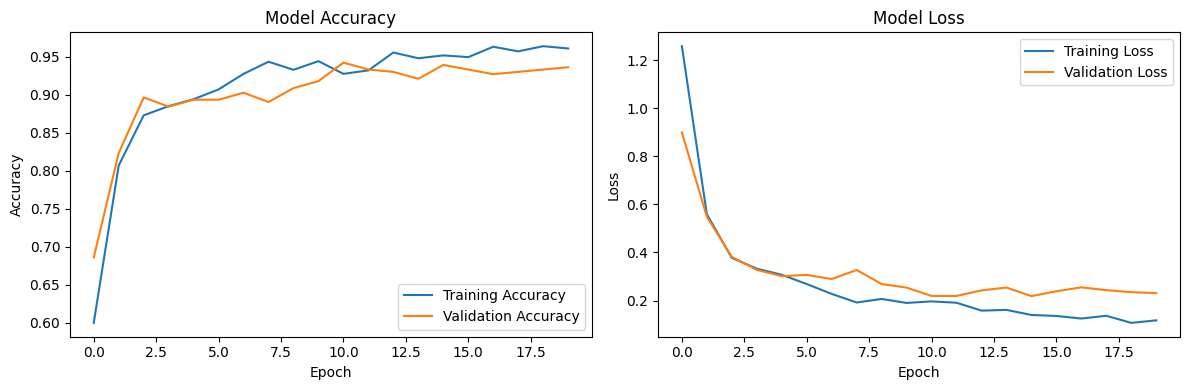

In [ ]:
# Visualisasi Training History
def plot_training_history(history):
    plt.figure(figsize=(12,4))

    # Plot accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualisasi history training
plot_training_history(history)


In [ ]:
# Prediksi dan klasifikasi
def predict_and_print(generator, model):
    # Ambil beberapa gambar dari generator
    images, labels = next(generator)

    # Prediksi
    predictions = model.predict(images)

    # Cetak prediksi vs aktual
    for i in range(len(images)):
        pred_class = np.argmax(predictions[i])
        true_class = np.argmax(labels[i])

        print(f"Prediksi: {list(desired_mapping.keys())[list(desired_mapping.values()).index(pred_class)]}")
        print(f"Aktual: {list(desired_mapping.keys())[list(desired_mapping.values()).index(true_class)]}")
        print("---")

# Jalankan prediksi
predict_and_print(test_generator, model)

1/1 [==============================] - 1s 839ms/step
Prediksi: 1k
Aktual: 1k
---
Prediksi: 5k
Aktual: 5k
---
Prediksi: 100k
Aktual: 100k
---
Prediksi: 1k
Aktual: 1k
---
Prediksi: 10k
Aktual: 10k
---
Prediksi: 20k
Aktual: 20k
---
Prediksi: 20k
Aktual: 20k
---
Prediksi: 5k
Aktual: 5k
---
Prediksi: 100k
Aktual: 100k
---
Prediksi: 100k
Aktual: 100k
---
Prediksi: 20k
Aktual: 20k
---
Prediksi: 20k
Aktual: 20k
---
Prediksi: 10k
Aktual: 5k
---
Prediksi: 10k
Aktual: 10k
---
Prediksi: 50k
Aktual: 50k
---
Prediksi: 100k
Aktual: 100k
---


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Fungsi untuk memuat dan mempersiapkan gambar
def load_and_prepare_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size)  # Muat gambar dan sesuaikan ukurannya
    img_array = image.img_to_array(img)  # Ubah gambar menjadi array
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array /= 255.0  # Normalisasi (jika model memerlukan normalisasi)
    return img_array

# Prediksi dan klasifikasi untuk gambar tunggal
def predict_and_print_single_image(image_path, model, target_size):
    # Muat dan persiapkan gambar
    img_array = load_and_prepare_image(image_path, target_size)

    # Prediksi
    predictions = model.predict(img_array)

    # Ambil kelas prediksi
    pred_class = np.argmax(predictions[0])  # Ambil prediksi untuk gambar tunggal

    # Cetak prediksi
    print(f"Prediksi: {list(desired_mapping.keys())[list(desired_mapping.values()).index(pred_class)]}")
    print("---")

# Path gambar yang ingin diprediksi
image_path = '/content/drive/MyDrive/Project_Bangkit/uang1.jpg'

# Tentukan ukuran target yang sesuai dengan input model Anda
target_size = (224, 224)  # Sesuaikan dengan ukuran input model Anda

# Jalankan prediksi untuk gambar tunggal
predict_and_print_single_image(image_path, model, target_size)


1/1 [==============================] - 0s 46ms/step
Prediksi: 50k
---


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Definisikan ukuran gambar sesuai model
IMG_SIZE = (224, 224)  # Sesuaikan dengan ukuran input model Anda

# Definisikan mapping label ke nama kategori
label_mapping = {0: '1k', 1: '2k', 2: '5k', 3: '10k', 4: '20k', 5: '50k', 6: '100k'}

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path, img_size=IMG_SIZE):
    # Muat gambar
    img = load_img(image_path, target_size=img_size)
    # Ubah gambar ke array
    img_array = img_to_array(img)
    # Normalisasi (rescale) nilai piksel
    img_array = img_array / 255.0
    # Tambahkan dimensi batch
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Lakukan prediksi pada gambar
def predict_images(model, image_paths):
    predictions = []
    for path in image_paths:
        # Preproses gambar
        img_array = preprocess_image(path)
        # Lakukan prediksi
        prediction = model.predict(img_array)
        # Ambil indeks label dengan probabilitas tertinggi
        predicted_label = np.argmax(prediction, axis=1)[0]
        # Tambahkan hasil ke daftar
        predictions.append(label_mapping[predicted_label])
    return predictions

# Daftar path gambar
test_image_paths = [
    '/content/drive/MyDrive/Project_Bangkit/uang100k.jpg',
    '/content/drive/MyDrive/Project_Bangkit/uang50k.jpg',
    '/content/drive/MyDrive/Project_Bangkit/uang20k.jpg',
    '/content/drive/MyDrive/Project_Bangkit/uang10k.jpg',
    '/content/drive/MyDrive/Project_Bangkit/uang5k.jpg',
    '/content/drive/MyDrive/Project_Bangkit/uang2k.jpg',
    '/content/drive/MyDrive/Project_Bangkit/uang1k.jpg',
    '/content/drive/MyDrive/Project_Bangkit/100wa.jpg',
    '/content/drive/MyDrive/Project_Bangkit/50wa.jpg',
    '/content/drive/MyDrive/Project_Bangkit/20wa.jpg',
    '/content/drive/MyDrive/Project_Bangkit/100wa2.jpg',
    '/content/drive/MyDrive/Project_Bangkit/2wa.jpg',
    '/content/drive/MyDrive/Project_Bangkit/1wa.jpg'
]

# Lakukan prediksi
predictions = predict_images(model, test_image_paths)

# Tampilkan hasil prediksi
for path, prediction in zip(test_image_paths, predictions):
    print(f"Gambar: {path} --> Prediksi: {prediction}")


1/1 [==============================] - 0s 29ms/step
Gambar: /content/drive/MyDrive/Project_Bangkit/uang100k.jpg --> Prediksi: 100k
Gambar: /content/drive/MyDrive/Project_Bangkit/uang50k.jpg --> Prediksi: 50k
Gambar: /content/drive/MyDrive/Project_Bangkit/uang20k.jpg --> Prediksi: 20k
Gambar: /content/drive/MyDrive/Project_Bangkit/uang10k.jpg --> Prediksi: 10k
Gambar: /content/drive/MyDrive/Project_Bangkit/uang5k.jpg --> Prediksi: 50k
Gambar: /content/drive/MyDrive/Project_Bangkit/uang2k.jpg --> Prediksi: 2k
Gambar: /content/drive/MyDrive/Project_Bangkit/uang1k.jpg --> Prediksi: 1k
Gambar: /content/drive/MyDrive/Project_Bangkit/100wa.jpg --> Prediksi: 50k
Gambar: /content/drive/MyDrive/Project_Bangkit/50wa.jpg --> Prediksi: 5k
Gambar: /content/drive/MyDrive/Project_Bangkit/20wa.jpg --> Prediksi: 20k
Gambar: /content/drive/MyDrive/Project_Bangkit/100wa2.jpg --> Prediksi: 5k
Gambar: /content/drive/MyDrive/Project_Bangkit/2wa.jpg --> Prediksi: 10k
Gambar: /content/drive/MyDrive/Project_Ban

#simpan model

In [ ]:
# Simpan model ke format HDF5 (.h5)
saved_model_path = "/content/drive/MyDrive/Proyek_Bangkit1/Uang_Baru/final2_model.h5"
model.save(saved_model_path)

print(f"Model berhasil disimpan ke: {saved_model_path}")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model berhasil disimpan ke: /content/drive/MyDrive/Proyek_Bangkit1/Uang_Baru/final2_model.h5


#convert tfjs

In [ ]:
!tensorflowjs_converter --input_format=keras \
/content/drive/MyDrive/Proyek_Bangkit1/Uang_Baru/final2_model.h5 \
/content/drive/MyDrive/Proyek_Bangkit1/Uang_Baru/final2_tfjs_model

2024-12-11 18:19:03.514808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 18:19:03.514878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 18:19:03.517137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 18:19:05.244171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#convert tflite

In [ ]:
import tensorflow as tf

# Path ke model .h5
model_path = '/content/drive/MyDrive/Proyek_Bangkit1/Uang_Baru/final2_model.h5'

# Muat model .h5
model = tf.keras.models.load_model(model_path)

# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke path yang diinginkan
tflite_model_path = '/content/drive/MyDrive/Proyek_Bangkit1/Uang_Baru/final2_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model TFLite telah disimpan di: {tflite_model_path}")


Model TFLite telah disimpan di: /content/drive/MyDrive/Proyek_Bangkit1/Uang_Baru/final2_model.tflite


In [ ]:
import tensorflow as tf

# Muat model TFLite
tflite_model_path = '/content/drive/MyDrive/Proyek_Bangkit1/Uang_Baru/final2_model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

# Alokasikan tensor input dan output
interpreter.allocate_tensors()

# Dapatkan informasi tensor input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

# Lakukan prediksi menggunakan data contoh (contoh input gambar)
import numpy as np
input_data = np.random.rand(1, 224, 224, 3).astype(np.float32)  # Ganti dengan input yang sesuai
interpreter.set_tensor(input_details[0]['index'], input_data)

# Jalankan model
interpreter.invoke()

# Ambil hasil prediksi
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Prediksi:", output_data)


Input details: [{'name': 'serving_default_mobilenetv2_1.00_224_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 180, 'shape': array([1, 7], dtype=int32), 'shape_signature': array([-1,  7], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Prediksi: [[9.8838878e-05 5.8879209e-08 2.8518539e-08 8.4894801e-08 9.9989676e-01
  4.1902913e-06 1.4103954e-07]]


In [ ]:
# Menampilkan hasil prediksi dalam format yang lebih mudah dimengerti
predicted_class = np.argmax(output_data)
print(f"Prediksi kelas: {predicted_class}")


Prediksi kelas: 4


In [ ]:
# Mapping kelas dengan label sesuai dengan indeks yang diberikan
class_mapping = {0: '1k', 1: '2k', 2: '5k', 3: '10k', 4: '20k', 5: '50k', 6: '100k'}

# Ambil kelas dengan probabilitas tertinggi dari output prediksi
predicted_class = np.argmax(output_data)

# Tampilkan nama kelas dan probabilitasnya
predicted_label = class_mapping[predicted_class]
predicted_probability = output_data[0][predicted_class]

print(f"Prediksi kelas: {predicted_label} dengan probabilitas {predicted_probability:.4f}")


Prediksi kelas: 20k dengan probabilitas 0.9999


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load model
model_path = '/content/drive/MyDrive/Proyek_Bangkit1/Uang_Baru/final2_model.h5'
model = tf.keras.models.load_model(model_path)

# Mapping kelas dengan label sesuai indeks
class_mapping = {0: '1k', 1: '2k', 2: '5k', 3: '10k', 4: '20k', 5: '50k', 6: '100k'}

# Fungsi untuk memuat dan memproses gambar
def prepare_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)  # Memuat gambar dengan ukuran tertentu
    img_array = img_to_array(img)  # Mengubah gambar ke array
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan batch dimension
    img_array = img_array / 255.0  # Normalisasi (opsional, tergantung preprocessing saat training)
    return img_array

# Path ke gambar yang akan diuji
test_image_paths = [
    '/content/drive/MyDrive/Project_Bangkit/uang1.jpg',
    '/content/drive/MyDrive/Project_Bangkit/uang50k.jpg',
    '/content/drive/MyDrive/Project_Bangkit/uang20k.jpg',
    '/content/drive/MyDrive/Project_Bangkit/uang10k.jpg',
    '/content/drive/MyDrive/Project_Bangkit/uang5k.jpg',
    '/content/drive/MyDrive/Project_Bangkit/uang2k.jpg',
    '/content/drive/MyDrive/Project_Bangkit/uang1k.jpg'
]

# Siapkan ukuran input model
target_size = (224, 224)  # Sesuaikan dengan ukuran input model Anda

# Lakukan prediksi untuk setiap gambar
for image_path in test_image_paths:
    # Siapkan gambar
    test_image = prepare_image(image_path, target_size)

    # Prediksi
    predictions = model.predict(test_image)
    predicted_class = np.argmax(predictions, axis=-1)[0]  # Ambil indeks dengan probabilitas tertinggi

    # Ambil label berdasarkan mapping
    label = class_mapping[predicted_class]

    # Tampilkan hasil dengan kelas
    print(f"Gambar: {image_path}")
    print(f"Prediksi: {label} (Kelas {predicted_class})")
    print("-" * 40)


1/1 [==============================] - 1s 1s/step
Gambar: /content/drive/MyDrive/Project_Bangkit/uang1.jpg
Prediksi: 50k (Kelas 5)
----------------------------------------
1/1 [==============================] - 0s 34ms/step
Gambar: /content/drive/MyDrive/Project_Bangkit/uang50k.jpg
Prediksi: 50k (Kelas 5)
----------------------------------------
1/1 [==============================] - 0s 43ms/step
Gambar: /content/drive/MyDrive/Project_Bangkit/uang20k.jpg
Prediksi: 20k (Kelas 4)
----------------------------------------
1/1 [==============================] - 0s 51ms/step
Gambar: /content/drive/MyDrive/Project_Bangkit/uang10k.jpg
Prediksi: 10k (Kelas 3)
----------------------------------------
1/1 [==============================] - 0s 46ms/step
Gambar: /content/drive/MyDrive/Project_Bangkit/uang5k.jpg
Prediksi: 50k (Kelas 5)
----------------------------------------
1/1 [==============================] - 0s 46ms/step
Gambar: /content/drive/MyDrive/Project_Bangkit/uang2k.jpg
Prediksi: 2k (K